EDA - Glovo Orders

-Clarice Mottet

Goal: forecast number of orders for every hour for a week ahead in BCN

Outline:
-Data Checks
-Distribution of order information
-Time dependence (trend, seasonality)
-Serial dependence (cycles)
-Stationarity

In [76]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess


XSMALL_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=XSMALL_SIZE)           # controls default text sizes\\n\",\n",
plt.rc('axes', titlesize=XSMALL_SIZE)     # fontsize of the axes title\\n\",\n",
plt.rc('axes', labelsize=XSMALL_SIZE)    # fontsize of the x and y labels\\n\",\n",
plt.rc('xtick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('ytick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('legend', fontsize=XSMALL_SIZE)    # legend fontsize\\n\",\n",
plt.rc('figure', titlesize=XSMALL_SIZE)  # fontsize of the figure title\\n\",\n",
plt.rc('figure', figsize=(7, 2))
plt.rc('figure', dpi=200)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

#paths
path_in_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/outputs/'


#global variables
TARGET = 'orders'

In [52]:
#import data into python

df_orders = pd.read_csv(path_in_ + 'data_BCN.csv', dtype = str)
df_orders['time'] = pd.to_datetime(df_orders['time'])
df_orders['orders'] = pd.to_numeric(df_orders['orders'])

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

## Data Checks

In [53]:
#basic stats - time

df_orders[['time']].describe().T

,count,mean,min,25%,50%,75%,max
time,8766,2021-08-03 01:57:28.459958784,2021-02-01 00:00:00,2021-05-03 13:15:00,2021-08-03 02:30:00,2021-11-02 15:45:00,2022-02-01 23:00:00


Start Time: 2021-02-01
  End Time: 2022-02-01

Data appears to be on hourly level.

In [54]:
#data checks - null, duplicates, missing?

#are there any orders with null information?
print("number of null orders:",df_orders['orders'].isna().sum())

#do we have duplicate order information?
df_view = df_orders.copy()
df_view.drop_duplicates(subset = ['time'], inplace = True)
print("import row count:", len(df_orders['time']))
print("post dup rmv row count:", len(df_view['time']))
del df_view

#are we missing any minute by minute order information?
start_time = pd.to_datetime('2021-02-01')
end_time = pd.to_datetime('2022-02-02')
date_range = pd.date_range(start=start_time, end=end_time, freq='h')
df_all = pd.DataFrame(date_range, columns=['time_all'])

df_all = df_all.merge(df_orders[['time']], how = 'left', left_on = ['time_all'], right_on = ['time'])
print("number of hours missing:",df_all['time'].isna().sum())
df_all_msng = df_all[df_all['time'].isna()].copy()
print("hours missing order information:")
print(df_all_msng)


number of null orders: 0
import row count: 8766
post dup rmv row count: 8766
number of hours missing: 19
hours missing order information:
                time_all time
336  2021-02-15 00:00:00  NaT
337  2021-02-15 01:00:00  NaT
338  2021-02-15 02:00:00  NaT
339  2021-02-15 03:00:00  NaT
340  2021-02-15 04:00:00  NaT
341  2021-02-15 05:00:00  NaT
3024 2021-06-07 00:00:00  NaT
3025 2021-06-07 01:00:00  NaT
3026 2021-06-07 02:00:00  NaT
3027 2021-06-07 03:00:00  NaT
3028 2021-06-07 04:00:00  NaT
3029 2021-06-07 05:00:00  NaT
6216 2021-10-18 00:00:00  NaT
6217 2021-10-18 01:00:00  NaT
6218 2021-10-18 02:00:00  NaT
6219 2021-10-18 03:00:00  NaT
6220 2021-10-18 04:00:00  NaT
6221 2021-10-18 05:00:00  NaT
8784 2022-02-02 00:00:00  NaT


There are 19 hours where we are missing order information taking place over 4 days for multiple consecutive hours.

Just as a placeholder, I'm going to use the average order information but only for data before the point where there is a null value

In [55]:
#add in the hours that the orders data frame is currently missing

#create cumulative sums for running average
df_orders['hour'] = df_orders['time'].dt.hour
df_orders['dayofweek'] = df_orders['time'].dt.day_of_week
df_orders['hours_cumulative'] = 1
df_orders['hours_cumulative'] = df_orders.groupby(by = ['hour','dayofweek'])['hours_cumulative'].cumsum()
df_orders['orders_cumulative'] = df_orders['orders']
df_orders['orders_cumulative'] = df_orders.groupby(by = ['hour','dayofweek'])['orders_cumulative'].cumsum()

#add in the missing hours
df_orders = df_all[['time_all']].merge(df_orders, how = 'left', left_on = ['time_all'], right_on = ['time'])
df_orders.sort_values(by = ['time_all'], inplace = True)

#fill in the missing averages
df_orders['hour'] = df_orders['time_all'].dt.hour
df_orders['dayofweek'] = df_orders['time_all'].dt.day_of_week
df_orders['city'] = df_orders['city'].ffill()
df_orders['hours_cumulative'] = df_orders.groupby(by = ['hour','dayofweek'])['hours_cumulative'].ffill()
df_orders['orders_cumulative'] = df_orders.groupby(by = ['hour','dayofweek'])['orders_cumulative'].ffill()
df_orders.loc[df_orders['orders'].isna(), 'orders'] = (df_orders['orders_cumulative']/df_orders['hours_cumulative']).round()

print("number of nulls",df_orders['orders'].isna().sum())

df_orders_msng = df_orders[df_orders['time'].isna()].copy()
print(df_orders_msng)

df_orders.loc[df_orders['time'].isna(), 'time'] = df_orders['time_all']
df_orders.sort_values(by = ['time_all'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)
df_orders = df_orders[['time', 'orders', 'city']]

number of nulls 0
                time_all time  orders city  hour  dayofweek  hours_cumulative  \
336  2021-02-15 00:00:00  NaT     0.0  BCN     0          0               2.0   
337  2021-02-15 01:00:00  NaT     0.0  BCN     1          0               2.0   
338  2021-02-15 02:00:00  NaT     0.0  BCN     2          0               2.0   
339  2021-02-15 03:00:00  NaT     0.0  BCN     3          0               2.0   
340  2021-02-15 04:00:00  NaT     0.0  BCN     4          0               2.0   
341  2021-02-15 05:00:00  NaT     0.0  BCN     5          0               2.0   
3024 2021-06-07 00:00:00  NaT     0.0  BCN     0          0              17.0   
3025 2021-06-07 01:00:00  NaT     0.0  BCN     1          0              17.0   
3026 2021-06-07 02:00:00  NaT     0.0  BCN     2          0              17.0   
3027 2021-06-07 03:00:00  NaT     0.0  BCN     3          0              17.0   
3028 2021-06-07 04:00:00  NaT     0.0  BCN     4          0              17.0   
3029 2021-

## Distribution of Order Information

In [56]:
#general statistics

df_orders[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,8785.0,72.99,110.97,0.0,0.0,30.0,96.0,939.0


array([[<AxesSubplot:title={'center':'orders'}>]], dtype=object)

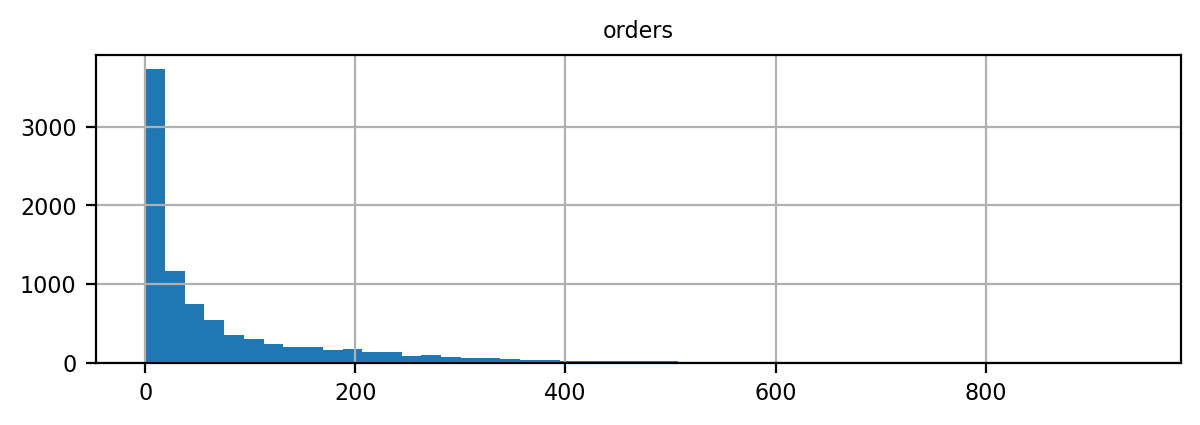

In [74]:
df_orders[[TARGET]].hist(bins=50)

## Evaluate Time Dependence

In [83]:
#extract out features from time field (hour, day, month, year)

df_orders['year'] = df_orders['time'].dt.year
df_orders['month'] = df_orders['time'].dt.month
df_orders['day'] = df_orders['time'].dt.day
df_orders['hour'] = df_orders['time'].dt.hour
df_orders['date'] = pd.to_datetime(df_orders[['year','month','day']])
df_orders['dayofweek'] = df_orders['time'].dt.day_of_week
df_orders['dayofyear'] = df_orders['time'].dt.day_of_year

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

df_orders['time_index'] = 1
df_orders['time_index'] = df_orders['time_index'].cumsum()
df_orders.set_index('time', inplace = True)


Trend:
-hour level for full time period (time, target)
-add moving average to graph

Seasonality:
-24 hour level in a day (hour, target)
-day level in a week (dayofweek, target)
-day level in a month (day, target)
-day level in a year (dayofyear, target)

[Text(0.5, 1.0, 'time vs target'), Text(0, 0.5, 'target')]

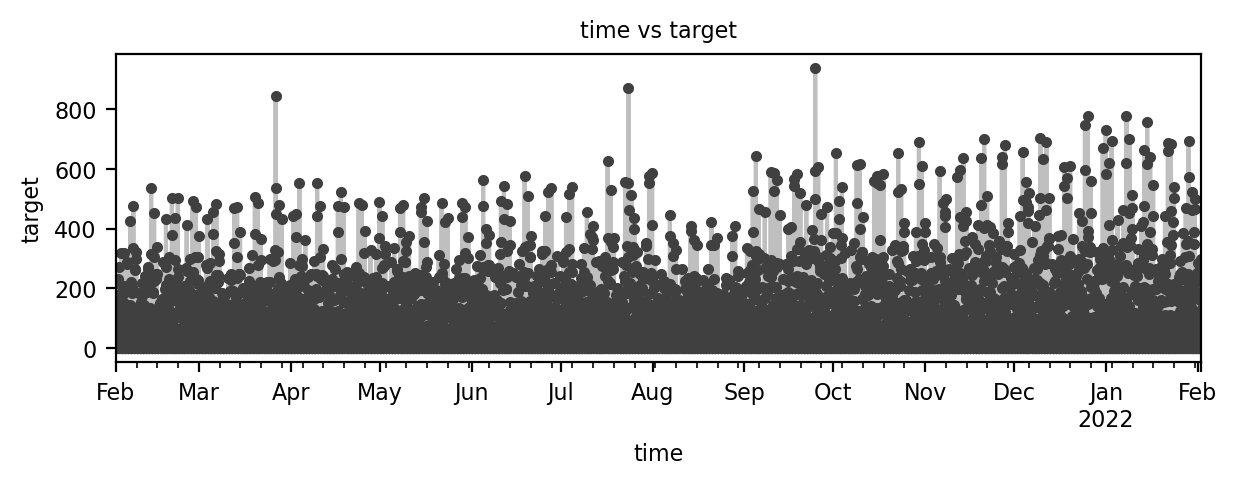

In [84]:
#Trend - hour level for full time period (time, target)

x_val = 'time'
y_val = TARGET

ax = df_orders.plot(x = x_val, y = y_val, **plot_params)
ax.set(title = x_val+' vs target', ylabel = 'target')

[Text(0.5, 1.0, 'date vs target'), Text(0, 0.5, 'target')]

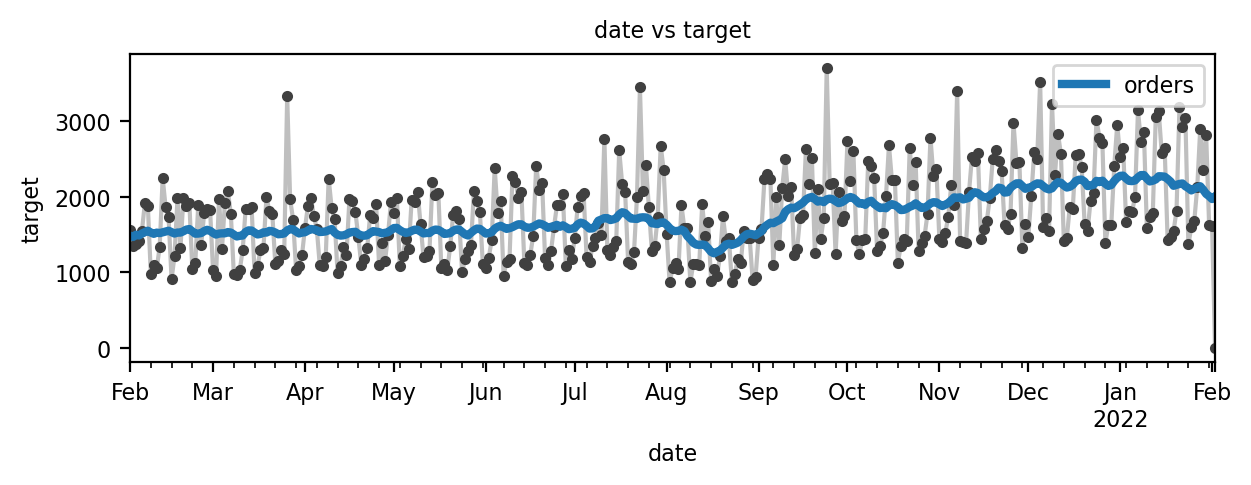

In [97]:
#aggregate to the day level number of orders, moving average

x_val = 'date'
y_val = TARGET

df_orders_agg = df_orders.groupby([x_val], as_index = False)['orders'].sum()
ax = df_orders_agg.plot(x = x_val, y = y_val, **plot_params)

df_orders_agg.set_index(x_val, inplace = True)
moving_average = df_orders_agg[[TARGET]].rolling(
    window=30,    
    center=True,
    min_periods = 15
).mean()       

ax = moving_average.plot(ax=ax, linewidth=3)
ax.set(title = x_val+' vs target', ylabel = 'target')

[2.13036751]
1355.1257292178495


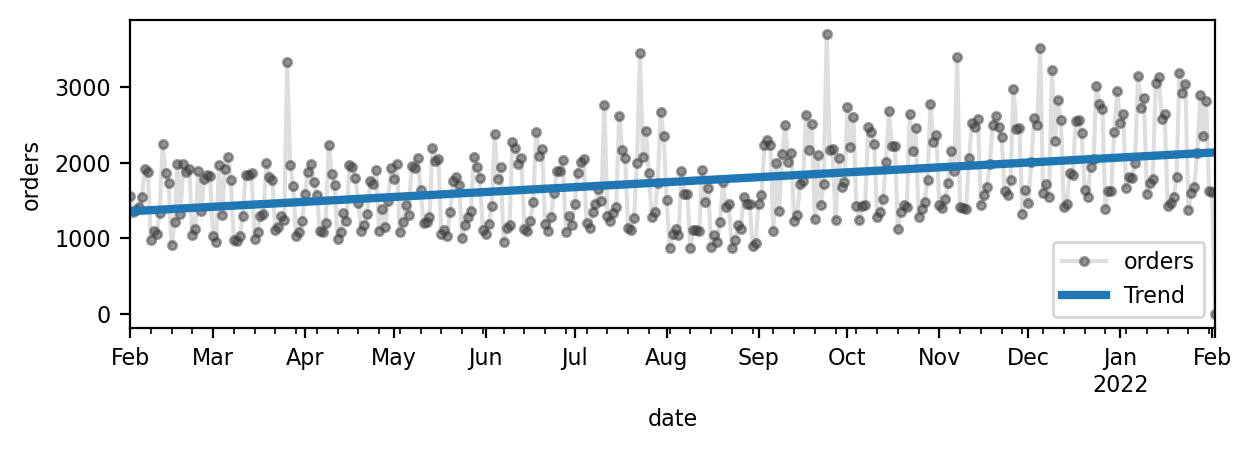

In [120]:
#see if we can make a good trend forecast

#aggregate orders to the day level
df_orders_agg = df_orders.groupby(['date'])['orders'].sum()

#suggested method from kaggle
dp = DeterministicProcess(
    index=df_orders_agg.index,
    order=1,             
    drop=True,           
)

X = dp.in_sample()
y = df_orders_agg.copy()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, ylabel="orders")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

print(model.coef_)
print(model.intercept_)

                     orders city  year  month  day  hour  dayofweek  \
time                                                                  
2021-02-01 00:00:00     0.0  BCN  2021      2    1     0          0   
2021-02-01 01:00:00     0.0  BCN  2021      2    1     1          0   
2021-02-01 02:00:00     0.0  BCN  2021      2    1     2          0   
2021-02-01 03:00:00     0.0  BCN  2021      2    1     3          0   
2021-02-01 04:00:00     0.0  BCN  2021      2    1     4          0   
...                     ...  ...   ...    ...  ...   ...        ...   
2021-02-04 23:00:00     0.0  BCN  2021      2    4    23          3   
2021-02-05 00:00:00     0.0  BCN  2021      2    5     0          4   
2021-02-05 01:00:00     0.0  BCN  2021      2    5     1          4   
2021-02-05 02:00:00     0.0  BCN  2021      2    5     2          4   
2021-02-05 03:00:00     0.0  BCN  2021      2    5     3          4   

                     dayofyear  time_index       date  trend_daily  \
time  

[Text(0.5, 1.0, 'date vs target'), Text(0, 0.5, 'target')]

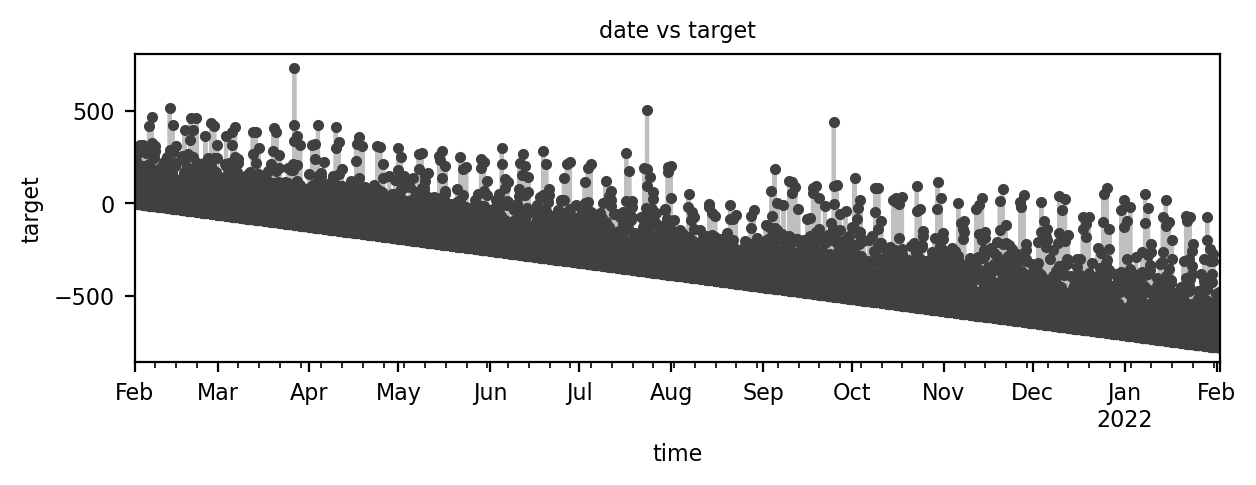

In [129]:
#remove the trend from the hourly time series data


# model.predict(X)
df_orders['trend_daily'] = df_orders.index.normalize().map(y_pred)

df_orders['orders_no_trend'] = df_orders['orders'] - df_orders['trend_daily']

print(df_orders.head(100))

ax = df_orders.plot(y = 'orders_no_trend', **plot_params)
ax.set(title = x_val+' vs target', ylabel = 'target')